In [1]:
import numpy as np
import torch
from torch import nn, optim
import gymnasium as gym
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

''' 이동 평균 계산 함수 '''
def running_mean(x, N=50):
    kernel = np.ones(N) # N개의 1로 채워진 1차원 ndarray
    conv_len = x.shape[0] - N # N개의 데이터 씩 이동 평균을 구하기 위해 몇 번째 데이터에서 반복을 멈춰야 하는지 결정한다 
    y = np.zeros(conv_len + 1) # conv_len + 1개의 0으로 채워진 1차원 ndarray

    # M개의 데이터를 N개 씩 묶어 이동 평균을 계산했을 때 산출되는 이동 평균의 개수
    # = M - N + 1
    for i in range(conv_len + 1): # +1을 해주어야 마지막 데이터까지 이동 평균 계산에 활용할 수 있다
        y[i] = kernel @ x[i:i+N] # @는 행렬곱을 의미하며, 행렬곱을 통해 N개의 데이터의 합을 계산한다(이러한 이유로 내부 원소가 1로 채워진 kernel이 존재한다)
        y[i] /= N # 이동 평균 계산

    return y

''' 할인된 보상 계산 함수 '''
def discount_rewards(rewards, gamma=0.99):
    len_r = len(rewards) # 에피소드에서 받은 보상의 개수
    # time step이 에피소드의 끝(에피소드의 패배)에 다가갈 수록 해당 time step이 에피소드의 패배에 어느 정도 관여한다고 가정한다
    disc_return = torch.pow(gamma, torch.arange(len_r).float()) * rewards # 할인된 보상 계산
    disc_return /= disc_return.max() # 할인된 보상을 [0, 1] 사이의 값으로 정규화한다(이는 모델 학습 안정성(혹은 수치적 안정성)을 위한 조치이다)

    return disc_return

env = gym.make("CartPole-v1") # 카트폴 환경 불러오기

spending time: 35.1634305 sec


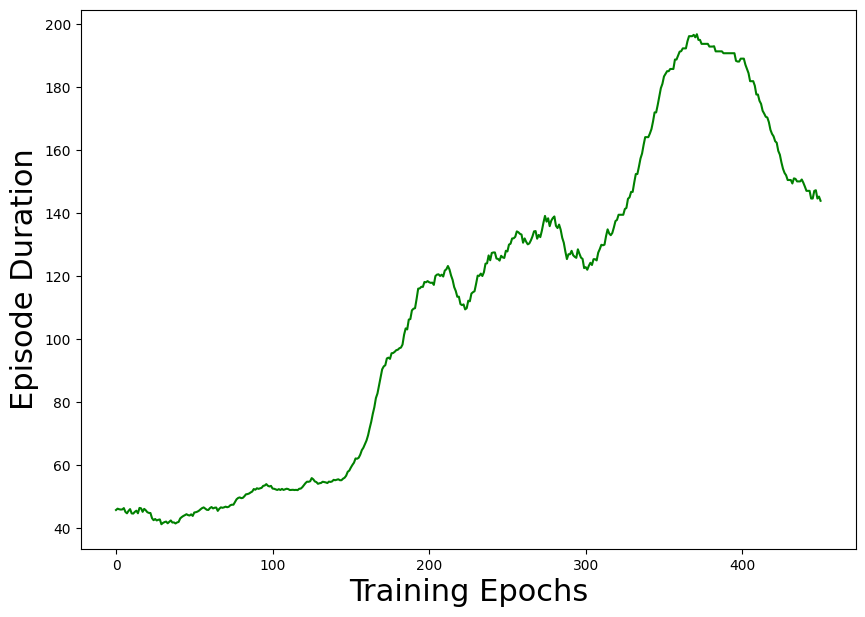

In [22]:
l1 = 4 # 입력층 노드의 개수
l2 = 150 # 첫번째 은닉층 노드의 개수
l3 = 2 # 출력층 노드의 개수 

model = nn.Sequential(
    nn.Linear(l1, l2),
    nn.LeakyReLU(),
    nn.Linear(l2, l3),
    nn.Softmax(dim=0) # 확률분포 계산을 위해 사용되었다
)

lr = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # 이상하게 SGD로는 제대로 학습되지 않는다
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.01) # SGD는 성능이 좋지 않다

def loss_fn(preds, r):
    # 에피소드 내의 각 행동에 대해 (할인된 보상이 곱해진)음의 로그 확률을 계산한 후, 그 총합을 loss로 한다
    return -1 * torch.sum(r * torch.log(preds)) # 이 때의 r은 "감마 X 총 수익(미래 수익)" 계산이 완료된 할인된 보상이다


''' 모델 학습 '''
''' gpu 사용 버전은 만들지 않는다
    이유는 텐서들을 cpu에서 gpu로 이동하는 i/o에서 지연이 발생하여,
    cpu로만 학습을 했을 때보다 느려지기 때문이다 '''
MAX_DUR = 200 # 에피소드 최대 길이(최대 time step 수)
MAX_EPISODES = 500 # 총 에피소드 수(= epoch)
gamma = 0.99 # 할인율
score = [] # 에피소드의 길이를 점수로 한다
expectation = 0.0 # 사용되지 않는데 왜 선언했는지 모르겠는 변수

start = time.time()
for episode in range(MAX_EPISODES):
    print(f"current episode {episode + 1}")
    
    curr_state = env.reset()[0] # 환경을 초기 상태로 초기화한 후, (상태, {})에서 상태만 가져온다
    done = False # 게임 종료 여부
    transitions = [] # 상태 전이 기록; 에피소드 내의 경험(상태, 행동, 보상으로 구성된)을 저장한다

    for t in range(MAX_DUR):
        act_prob = model(torch.from_numpy(curr_state).float()) # 현재 상태에서 취할 수 있는 행동들에 대한 확률분포를 반환한다
        action = np.random.choice(np.array([0, 1]), p = act_prob.data.numpy()) # 두 개의 행동(좌로 이동, 우로 이동) 중 하나를 선택한다
        prev_state = curr_state
        curr_state, _, done, _, _ = env.step(action) # 선택한 행동을 취하여 다음 상태로 전이한다
        transitions.append((prev_state, action, t+1)) # 경험(현재 상태, 현재 상태에서 취한 행동, 그에 따른 보상) 생성
        if done: # 게임이 종료되면 반복을 중단한다
            break

    ep_len = len(transitions) # 에피소드의 길이(이를 점수로 본다)를 계산한다
    score.append(ep_len) # 점수 추가

    ''' 배치 학습 '''
    reward_batch = torch.tensor([r for (s, a, r) in transitions], dtype=torch.float).flip(dims=(0,)) # 데이터를 역순으로 뒤집어 나열하여 총 수익이 각 time step에 올바로 반영될 수 있도록 한다
    disc_returns = discount_rewards(reward_batch) # 할인된 보상을 계산한다
    state_batch = torch.tensor([s for (s, a, r) in transitions], dtype=torch.float) # ep_len X 4 형태의 텐서가 반환된다
    action_batch = torch.tensor([a for (s, a, r) in transitions], dtype=torch.float) # ep_len 크기의 1차원 텐서가 반환된다
    pred_batch = model(state_batch) # ep_len X 2의 텐서가 반환된다
    prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1, 1)).squeeze() # action_batch를 ep_len X 1 형태의 텐서로 변형한다; 최종적으로 ep_len 크기의 1차원 텐서가 반환된다

    ''' 역전파 '''
    loss = loss_fn(prob_batch, disc_returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    clear_output(wait=True)
end = time.time()
print(f"spending time: {end - start:.7f} sec")

''' 이동 평균 계산 '''
score = np.array(score)
avg_score = running_mean(score, 50)

''' 시각화 '''
plt.figure(figsize=(10, 7))
plt.ylabel("Episode Duration", fontsize=22)
plt.xlabel("Training Epochs", fontsize=22)
plt.plot(avg_score, color="green")

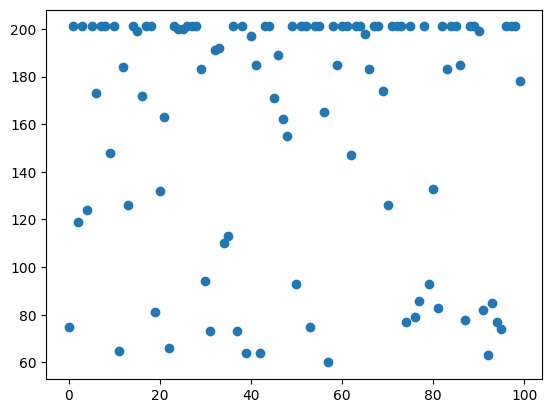

In [24]:
MAX_DUR = 200 # 에피소드 최대 길이(최대 time step 수)
score = [] # 점수들 모음
games = 100 # 총 게임 횟수

for i in range(games):
    state1 = env.reset()[0] # 게임 환경을 초기 상태로 초기화한 후, 초기 상태 반환
    done = False # 게임 종료 여부
    t = 0 # 에피소드 길이
    
    while not done: # done = False이면 에피소드를 계속 진행한다
        pred = model(torch.from_numpy(state1).float()) # 현재 상태에서의 행동 집합에 대한 확률 분포를 반환한다; 2차원 벡터
        action = np.random.choice(np.array([0, 1]), p=pred.data.numpy()) # 반환된 확률분포를 기반으로 행동을 선택한다
        state2, reward, done, _, info = env.step(action) # 선택한 행동을 취하여 에피소드를 한 단계 진행한다
        state1 = state2 # 상태 갱신
        
        t += 1 # 보상 계산
        if t > MAX_DUR: # 에피소드의 최대 길이를 넘기면 승리로 간주하고 에피소드를 종료한다
            break
    score.append(t) # 에피소드 결과 점수 기록

score = np.array(score)
plt.scatter(np.arange(score.shape[0]), score) # 100번의 게임과 그에 따른 점수들로 이루어진 산점도를 그린다

spending time: 13.1104623 min


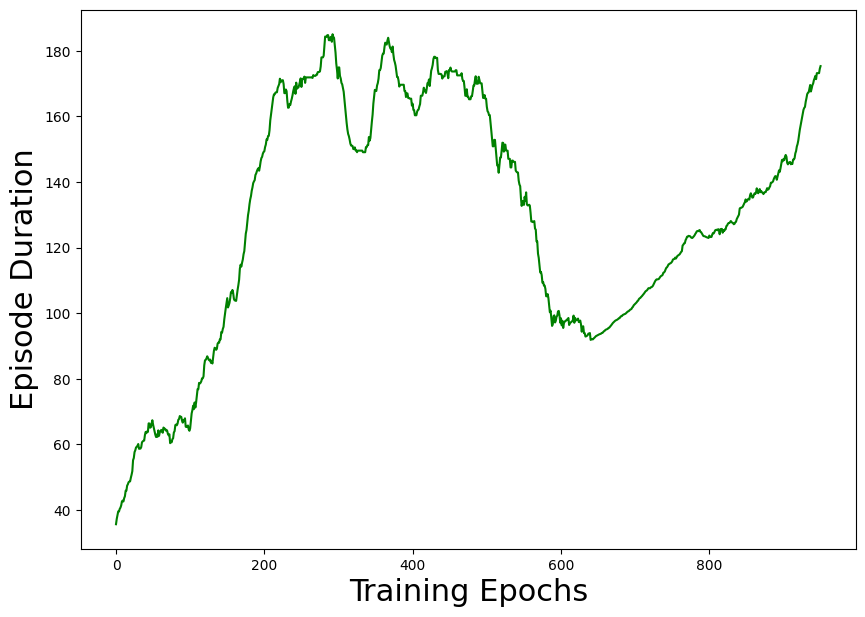

In [18]:
from collections import deque
import random

class LBLrD_block(nn.Module):
    def __init__(self, input_size, node, dropout):
        super().__init__()
        match input_size:
            case 0:
                self.linear = nn.Linear(node, node)
            case _:
                self.linear = nn.Linear(input_size, node)
        self.batch_norm = nn.BatchNorm1d(node)
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        output = self.dropout(self.leaky_relu(self.batch_norm(self.linear(x))))
        # output = self.dropout(self.leaky_relu(self.linear(x)))

        return output

class CustomModel(nn.Module):
    def __init__(self, input_size, total_hidden, node, dropout, output_size):
        super().__init__()
        # input block
        self.start_block = LBLrD_block(input_size, node, dropout)
        # hidden block
        match total_hidden:
            case 1:
                self.middle_block = LBLrD_block(0, node, dropout)
            case _:
                self.middle_block = self.make_middle_block(total_hidden-1, node, dropout)
        # output block
        self.linear = nn.Linear(node, output_size)
        self.softmax = nn.Softmax(dim=1) # dim=0이 아니라 dim=1로 설정해야 정상 작동한다

    def forward(self, x):
        output = self.start_block(x)
        output = self.middle_block(output)
        output = self.softmax(self.linear(output))

        return output

    def make_middle_block(self, total_hidden, node, dropout):
        return nn.Sequential(*[LBLrD_block(0, node, dropout) for _ in range(total_hidden)])

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current device name: {device}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Current the number of GPUs available: {torch.cuda.device_count()}")

''' replay memory 생성 '''
mem_size = 500
replay_memory = deque(maxlen=mem_size) # replay memory 생성; deque는 파이썬 내장 모듈인 collections로 부터 나온 것이다
batch_size = 256

model = CustomModel(input_size=4, total_hidden=5, node=256, dropout=0, output_size=2).to(device)

# ''' 목표망 생성(성능이 없으니만 못함) '''
# model2 = CustomModel(input_size=4, total_hidden=5, node=256, dropout=0.2, output_size=2).to(device)
# model2.load_state_dict(model.state_dict())
# sync_period = 500 # sync_period만큼의 time step이 지날 때마다 목표망을 갱신한다(sync_period > batch_size이어야만 목표망 갱신 주기에 맞추어 목표망을 갱신할 수 있다)
# count = 0 # 전체 에피소드에 대하여 time step의 수를 센다

lr = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) # SGD는 성능이 좋지 않다
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)

def loss_fn(preds, r):
    # 에피소드 내의 각 행동에 대해 (할인된 보상이 곱해진)음의 로그 확률을 계산한 후, 그 총합을 loss로 한다
    return -1 * torch.sum(r * torch.log(preds)) # 이 때의 r은 "감마 X 총 수익" 계산이 완료된 할인된 보상이다


''' 모델 학습 '''
''' gpu 사용 버전은 만들지 않는다
    이유는 텐서들을 cpu에서 gpu로 이동하는 i/o에서 지연이 발생하여,
    cpu로만 학습을 했을 때보다 느려지기 때문이다 '''
MAX_DUR = 200 # 에피소드 최대 길이(최대 time step 수)
MAX_EPISODES = 1000 # 총 에피소드 수(= epoch)
gamma = 0.99 # 할인율
score = [] # 에피소드의 길이를 점수로 한다

start = time.time()
for episode in range(MAX_EPISODES):
    print(f"current episode {episode + 1}")
    
    curr_state = env.reset()[0] # 환경을 초기 상태로 초기화한 후, (상태(ndarray이다), {})에서 상태만 가져온다
    done = False # 게임 종료 여부
    transitions = [] # 상태 전이 기록; 에피소드 내의 경험(상태, 행동, 보상)을 저장한다

    ''' 에피소드 한 번 실행 '''
    model.eval()
    for t in range(MAX_DUR):
        # count += 1
        with torch.no_grad():
            act_prob = model(torch.from_numpy(curr_state).float().view(1, 4).to(device)) # 현재 상태에서 취할 수 있는 행동들에 대한 확률분포를 반환한다
        action = torch.multinomial(act_prob, 1, replacement=True).squeeze().item() # 주어진 확률을 기반으로 한 확률분포에서 각 확률값을 가진 원소의 인덱스를 무작위로 1개 추출하여 반환한다
                                                                                   # 두 개의 행동(좌로 이동, 우로 이동) 중 하나를 선택한다
        prev_state = curr_state
        curr_state, _, done, _, _ = env.step(action) # 선택한 행동을 취하여 다음 상태로 전이한다
        transitions.append([prev_state.tolist(), action, t+1]) # 경험(현재 상태, 현재 상태에서 취한 행동, 그에 따른 보상) 생성
        if done: # 게임이 종료되면 반복을 중단한다
            break

    ep_len = len(transitions)
    score.append(ep_len) # 에피소드의 길이를 계산하여 점수로 추가한다
    
    total_return = np.flip([r for [s, a, r] in transitions]) # 데이터를 역순으로 뒤집어 나열하여 총 수익이 각 time step에 올바로 반영될 수 있도록 한다
    disc_rewards = np.power(gamma, total_return[0] - total_return) * total_return # 할인된 보상을 계산한다
    disc_rewards /= disc_rewards.max() # 할인된 보상의 정규화

    for i in range(ep_len):
        transitions[i][2] = disc_rewards[i] # 각 경험의 총 수익을 계산된 할인된 보상으로 교체한다
        replay_memory.append(transitions[i]) # 리플레이 메모리에 (경험)데이터를 저장한다

    ''' 배치 학습(경험 재현 기법 구현) '''
    if len(replay_memory) > batch_size:
        model.train() # model.train()을 사용하지 않아도 기본으로 학습 모드가 활성화된다
                      # 또한 학습 모드일 때는 반드시 학습 데이터를 1개 이상 넣어주어야 한다(그렇지 않으면 오류가 발생한다)
        minibatch = random.sample(replay_memory, batch_size) # 리플레이 메모리에서 batch_size개의 데이터를 무작위로 추출한다
        
        disc_reward_batch = torch.tensor([d_r for [s, a, d_r] in minibatch], dtype=torch.float, device=device) # batch_size X 1 형태의 텐서가 반환된다
        state_batch = torch.tensor([s for [s, a, d_r] in minibatch], dtype=torch.float, device=device) # batch_size X 4 형태의 텐서가 반환된다
        action_batch = torch.tensor([a for [s, a, d_r] in minibatch], dtype=torch.float, device=device) # batch_size 크기의 1차원 텐서가 반환된다
        pred_batch = model(state_batch) # batch_size X 2의 텐서가 반환된다; 주 정책 신경망이 아닌 목표망을 사용한다
        prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1, 1)).squeeze() # action_batch를 batch_size X 1 형태의 텐서로 변형한다; 최종적으로 크기가 batch_size인 1차원 텐서가 반환된다

        ''' 역전파 '''
        loss = loss_fn(prob_batch, disc_reward_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ''' 목표망 구현(성능이 없으니만 못함) '''
        # if count % sync_period == 0:
        #     model2.load_state_dict(model.state_dict()) # 주 정책 신경망의 매개변수를 불러와 목표망을 갱신한다

    # scheduler.step() # 학습률 갱신

    clear_output(wait=True)
end = time.time() # cpu = 104.6877906 sec / gpu = 72.0076778 sec
print(f"spending time: {(end - start) / 60:.7f} min")

''' 이동 평균 계산 '''
score = np.array(score)
avg_score = running_mean(score, 50)

''' 시각화 '''
plt.figure(figsize=(10, 7))
plt.ylabel("Episode Duration", fontsize=22)
plt.xlabel("Training Epochs", fontsize=22)
plt.plot(avg_score, color="green")

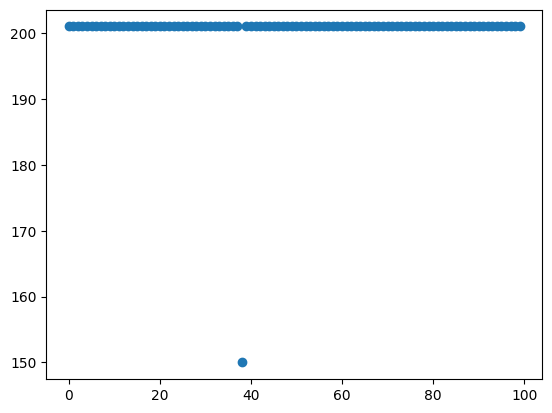

In [19]:
MAX_DUR = 200 # 에피소드 최대 길이(최대 time step 수)
score = []
games = 100 # 총 게임 횟수

for i in range(games):
    state1 = env.reset()[0] # 게임 환경을 초기 상태로 초기화한 후, 초기 상태 반환
    done = False # 게임 종료 여부
    t = 0

    print(f"Progress...{i + 1:^7.1f}")
    model.eval()
    while not done: # done = False이면 에피소드를 계속 진행한다
        with torch.no_grad():
            pred = model(torch.from_numpy(state1).float().view(1, 4).to(device)) # 현재 상태에서의 행동 집합에 대한 확률 분포를 반환한다; 2차원 벡터
        action = torch.multinomial(pred, 1, replacement=True).squeeze().item() # 반환된 확률분포를 기반으로 행동을 선택한다
        state2, reward, done, _, _ = env.step(action) # 선택한 행동을 취하여 에피소드를 한 단계 진행한다
        state1 = state2 # 상태 갱신
        
        t += 1 # 보상 계산(1 보상 = 1 time step)
        if t > MAX_DUR: # 에피소드의 최대 길이를 넘기면 승리로 간주하고 에피소드를 종료한다
            break
    score.append(t) # 에피소드 길이를 점수로 기록한다
    clear_output(wait=True)

score = np.array(score)
plt.scatter(np.arange(score.shape[0]), score) # 100번의 게임과 그에 따른 점수들로 이루어진 산점도를 그린다

In [7]:
state1 = env.reset() # 환경을 초기 상태로 초기화한다
print(state1, type(state1))
print("type of state1[0]: ", type(state1[0])) # 상태는 ndarray로 표현된다
print("type of state1[1]: ",type(state1[1]))

pred = model(torch.from_numpy(state1[0]))
action = np.random.choice(np.array([0, 1]), p=pred.data.numpy())
print("action: ", action, ", type of action: ", type(action))

state2, reward, done, truncated, info = env.step(action) # done = 게임 종료 여부, info = 디버깅을 위한 정보
print("reward: ", reward, ", type of reward: ", type(reward))
print("done: ", done, ", type of done: ", type(done))
print("truncated: ", truncated)
print("info: ", info)

(array([-0.00513325, -0.01341463, -0.0495    ,  0.00220038], dtype=float32), {}) <class 'tuple'>
type of state1[0]:  <class 'numpy.ndarray'>
type of state1[1]:  <class 'dict'>
action:  0 , type of action:  <class 'numpy.int32'>
reward:  1.0 , type of reward:  <class 'float'>
done:  False , type of done:  <class 'bool'>
truncated:  False
info:  {}


In [44]:
cur_state = env.reset()[0] # 환경 초기화

''' 카트폴 환경이 조금 이상한 것 같다
    게임이 종료 되면(게임에서 패배하면) 1.0이 아닌 다른 보상을 받아야 하는데,
    여기서는 게임이 종료되었음에도 1.0이 보상으로 반환된다'''
for i in range(20):
    # print(cur_state, cur_state[0], type(cur_state[0]))
    pred = model(torch.from_numpy(cur_state).float())
    action = np.random.choice(np.array([0, 1]), p=pred.data.numpy())
    # 2번째 상태부터는 (상태 벡터, {})이 아니라 상태 벡터만 반환된다
    cur_state, reward, done, info, _ = env.step(action) # done = 게임 종료 여부, info = 디버깅을 위한 정보

    print(f"{i}th reward: {reward}")
    print(f"{i}th done: {done}")
    if done:
        break

0th reward: 1.0
0th done: False
1th reward: 1.0
1th done: False
2th reward: 1.0
2th done: False
3th reward: 1.0
3th done: False
4th reward: 1.0
4th done: False
5th reward: 1.0
5th done: False
6th reward: 1.0
6th done: False
7th reward: 1.0
7th done: False
8th reward: 1.0
8th done: False
9th reward: 1.0
9th done: False
10th reward: 1.0
10th done: False
11th reward: 1.0
11th done: False
12th reward: 1.0
12th done: False
13th reward: 1.0
13th done: False
14th reward: 1.0
14th done: False
15th reward: 1.0
15th done: False
16th reward: 1.0
16th done: False
17th reward: 1.0
17th done: False
18th reward: 1.0
18th done: True
